# Épreuve de programmation: cycles et pseudo-cycles dans DES / AES

**LSE recrutement 2020 - 2021**

*Thomas Berlioz, thomas.berlioz, thomas.berlioz@epita.fr*

Quelques remarques utiles pour lire ce document:

- **SI** et **SEULEMENT SI** vous voulez exécuter tous les algorithmes, je suggère de run une fois toutes les cells (`Cell -> Run All`) **avant** la lecture du document afin que tous les graphiques soient affichés quand on arrive à leurs niveaux. Néanmoins, comme ils ont tous été lancés avant d'enregistrer ce document, ce n'est pas forcément utile car cela peut prendre jusqu'à **1 heure**. Un moyen facile de savoir si tout a été calculé et affiché est de se rendre à la **FIN** du document, et de vérifier que le *check* est affiché. C'est vraiment explicite, et beaucoup plus pratique qu'attendre le temps annoncé montre en main. Si cela prend vraiment trop de temps, il vaut mieux interrompre le kernel et recommencer, ça pourrait être lié à un cas extrême dans les calculs sur des chaines aléatoires.

- Les fonctions `distance` devraient représenter une mesure de différence au sens étymologique. Elles représentent ici une mesure de la similarité entre `a` et `b`, contrairement à ce qu'on pourrait attendre. Cela explique pourquoi elles ne sont pas normalisées, et également l'inégalité `<=` dans l'algorithme de recherche de cycle *approché* de Floyd.

- La *borne* dont le sujet parle est ici désignée par `radius`. *LCS* signifie *Longest Common Substring*, ou *plus longue sous-chaine* (de bits ou de caractères).

- L'analyse concrète des résultats arrive loin dans le document. Je trouvais ça plus intéressant d'avoir le cheminement pour arriver aux données concrètes et à l'analyse des quasi-cycles de la plus longue sous-chaine commune de bits ou de caractères. C'est pourquoi le début peut sembler répétitif ou facile, il m'a permis de mettre en place l'environnement de travail, de me familiariser avec les objets que je manipule et avec le sujet et ses problématiques.

- On remarque rapidement que je ne propage pas la valeur `debug` dans les sous-appels de fonctions. C'est volontaire, tout comme le fait que je précise parfois explicitement `debug=False` lors de l'appel alors que `debug = False` par défaut. C'est simplement plus pratique et plus visuel pour changer cette valeur pendant le debugging.

---

**Table of contents:**

- [Début du timer](#debut-du-timer)
- [I - Fonctions de base](#i---fonctions-de-base)
  * [1 - Algorithme de chiffrement](#1---algorithme-de-chiffrement)
  * [2 - Variante de l'algorithme de Floyd](#2---variante-de-lalgorithme-de-floyd)
- [II - Test de l'algorithme](#ii---test-de-lalgorithme)
  * [1 - Premières fonctions de distance](#1---premieres-fonctions-de-distance)
  * [2 - Observations](#2---observations)
- [III - Plus longue sous-chaine commune](#iii---plus-longue-sous-chaine-commune)
  * [1 - Fonctions de distance](#1---fonctions-de-distance)
  * [2 - Premières observations](#2---premieres-observations)
  * [3 - Différence caractères - bits](#3---difference-caracteres---bits)
- [IV - Analyse sur des LCS de bits](#iv---analyse-sur-des-lcs-de-bits)
  * [1 - Message initial](#1---message-initial)
    + [a - Entropie](#a---entropie)
    + [b - Patterns](#b---patterns)
    + [c - Taille](#c---taille)
  * [1 - Clé](#1---cle)
    + [a - Entropie](#a---entropie-1)
    + [b - Patterns](#b---patterns-1)
    + [c - Taille](#c---taille-1)
- [V - Conclusion](#v---conclusion)
- [Bonus](#bonus)
- [Fin du timer](#fin-du-timer)

---

## Début du timer

Cela permet de calculer le temps total de calcul et de valider que tous les calculs ont été faits à la fin du document.

In [98]:
import time
import datetime

global_start = time.time()
print("[x] starting computation...")

[x] starting computation...


---

## I - Fonctions de base

Il faut dans un premier temps choisir l'application qu'on utilisera dans l'algorithme de Floyd, puis coder la version modifiée de cet algorithme afin qu'il détecte des quasi-cycles.

### 1 - Algorithme de chiffrement

Tout d'abord, j'ai choisi pour algorithme AES-128 en mode ECB car il se trouve que j'avais déjà joué avec ce chiffrement en CTF, et que j'ai supposé que j'aurais plus de ressources (ou plus récentes) avec cet algorithme qu'avec DES.

J'ai donc commencé par coder deux fonctions pour facilement chiffrer et déchiffrer un message dans la suite du projet.

In [99]:
from Crypto.Cipher import AES

def encrypt(plain, key, debug=False):
    assert len(plain) % 16 == 0 and len(key) % 16 == 0
    AES_ECB = AES.new(key, AES.MODE_ECB)
    cipher = AES_ECB.encrypt(plain)
    if debug:
        print("[+] encrypting {} with key {} -> {}".format(plain, key, cipher))
    return cipher

def decrypt(cipher, key, debug=False):
    assert len(cipher) % 16 == 0 and len(key) % 16 == 0
    AES_ECB = AES.new(key, AES.MODE_ECB)
    plain = AES_ECB.decrypt(cipher)
    if debug:
        print("[+] decrypting {} with key {} -> {}".format(cipher, key, plain))
    return plain

J'ai rapidement testé ces deux fonctions avant de passer à la suite.

In [100]:
import binascii

def testAES():
    plain, key = "LSE_is_super_fun", "supersecretkey!!"
    cipher = encrypt(plain, key)
    decipher = decrypt(cipher, key)
    print(f"[x] plain = {plain}")
    print(f"[x] key = {key}")
    print(f"[x] cipher = {binascii.hexlify(cipher)}")
    print(f"[x] decipher = {decipher}")
    
testAES()

[x] plain = LSE_is_super_fun
[x] key = supersecretkey!!
[x] cipher = b'f2ec5961e21628c97afe36d4aeaed707'
[x] decipher = b'LSE_is_super_fun'


### 2 - Variante de l'algorithme de Floyd

J'ai ensuite codé l'algorithme de recherche de cycle *approché* de Floyd.

In [101]:
def floydRadius(f, x0, distance, radius, debug=False):
    """
    x0 -> f(x0) -> f(f(x0)) -> ... -> x -> ...

    when does x ~= x0?
    => when does distance(x0, x) <= radius?

    where distance measures:
    - number of common bits     OR
    - number of common chars   OR
    - length of longest common substring

    return m such as x_m == x_2m
    """
    if debug:
        print(f"[+] floydRadius with x0 = {x0}, radius = {radius}")
    m = 1
    tortoise = f(x0)
    hare = f(f(x0))
    while distance(tortoise, hare, debug=False) <= radius:
        m += 1
        tortoise = f(tortoise) # one step
        hare = f(f(hare)) # two steps
    if debug:
        print(f"[+] m = {m}")
        dist = distance(tortoise, hare, debug=True)
        print(f"[+] distance = {dist}")
        print(f"[+] tortoise = {binascii.hexlify(tortoise)}")
        print(f"[+] hare =     {binascii.hexlify(hare)}")
    return m

---

## II - Test de l'algorithme

### 1 - Premières fonctions de distance

Puis j'ai codé deux fonctions de distance différentes pour tester mon code, et pourquoi pas commencer à regarder le comportement des quasi-cycles dans AES-128-ECB avec simplement des observations de similarité de bits et de caractères.

In [102]:
def charCommon(a, b, debug=False): # distance function
    """
    return how many common chars `a` and `b` have
    """
    assert len(a) == len(b), f"Strings have different length: len(a) = {len(a)}, len(b) = {len(b)}"
    count = 0
    z = zip(a, b)
    for i, j in z:
        if i == j:
            count += 1
    return count

def getBinary(string):
    """
    return binary representation of string WITH leading zeroes and WITHOUT `0b` prefix
    """
    # `zfill` keep leading zeroes when converting to bin
    bit_string = bin(int(binascii.hexlify(string), 16))[2:].zfill(8 * len(string))
    return bit_string

def bitCommon(a, b, debug=False): # distance function
    """
    return how many common bits `a` and `b` have
    """
    assert len(a) == len(b), f"Strings have different length: len(a) = {len(a)}, len(b) = {len(b)}"
    bit_a = getBinary(a)
    bit_b = getBinary(b)
    bit_common = charCommon(bit_a, bit_b)
    if debug:
        print(f"[+] bit_a = {bit_a}")
        print(f"[+] bit_b = {bit_b}")
        print(f"[+] bit_common = {bit_common}")
    return bit_common

### 2 - Observations

Voyons ce que donnent quelques tours de l'algo avec la distance mesurant le nombre de bits communs.

In [103]:
import matplotlib.pyplot as plt
import numpy as np
    
def setAxs(axe, maxRadiuses, x, y, i):
    lim = maxRadiuses[i]
    if maxRadiuses[i] == 1:
        axe.plot(x[:lim], y[:lim], 'o')
    else:
        axe.plot(x[:lim], y[:lim])
    axe.set_xlabel("radius")
    axe.set_ylabel("index of cycle detection")
    # set x ticks
    xticks = axe.get_xticks()
    xticks[0], xticks[-1] = x[0], x[lim - 1]
    xticks[1], xticks[-2] = xticks[0], xticks[-1]
    axe.set_xticks(xticks)
    # set y ticks
    yticks = axe.get_yticks()
    yticks[0], yticks[-1] = y[0], y[lim - 1]
    yticks[1], yticks[-2] = yticks[0], yticks[-1]
    axe.set_yticks(yticks)
    
def maxRadiusCompare(plain, key, distance, maxRadiuses, height=3.2, width=12):
    """
    compare floydRadius(plain, key, distance, radius)
    for radius in range(1, maxRadius)
    for maxRadius in maxRadiuses
    """
    assert len(key) % 16 == 0 and len(plain) % 16 == 0
    def encrypt_plain(plain): # to avoid passing `key` arg in `floydRadius`
        return encrypt(plain, key)
    
    # compute x and y values
    print("[+] computing...")
    start = time.time()
    xlim = max(maxRadiuses)
    x = np.linspace(1, xlim, xlim)
    y = [floydRadius(encrypt_plain, plain, distance, radius) for radius in x]
    end = time.time()
    print(f"[+] done in {int(end - start)} secs")

    # build fig
    nb_sets = len(maxRadiuses) # nb graphs
    fig, axs = plt.subplots(nb_sets, sharex=False, sharey=False)
    fig.suptitle(f"distance with x0 = '{plain}' and key = '{key}'")
    fig.set_figheight(height * nb_sets)
    fig.set_figwidth(width)
    fig.tight_layout(pad=2)
    
    # build and show graphs
    if nb_sets > 1: # several graphs
        for i in range(nb_sets):
            setAxs(axs[i], maxRadiuses, x, y, i)
    else: # only one graph
        setAxs(axs, maxRadiuses, x, y, 0)
        
    plt.show()

[+] computing...
[+] done in 10 secs


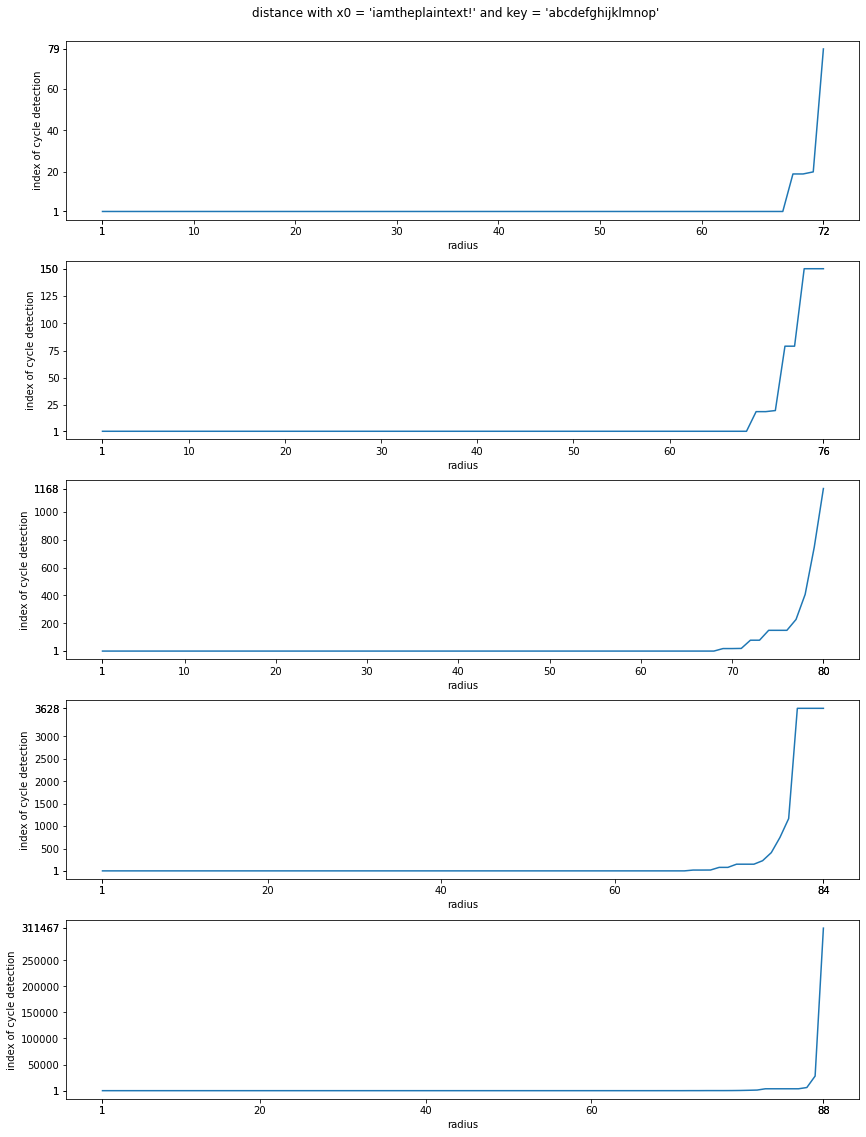

In [104]:
key = "abcdefghijklmnop"
plain = "iamtheplaintext!"
maxRadiuses = [72, 76, 80, 84, 88]
maxRadiusCompare(plain, key, bitCommon, maxRadiuses)

On voit déjà des choses intéressantes, comme des différences énormes dans l'index retourné par l'algorithme de Floyd à quelques bits près. Les différences sont si grandes que chaque bit commun supplémentaire rend négligeable le temps nécessaire pour les précédents. Après 90 bits en commun, la detection d'un quasi-cycle commençait à être trop longue pour être judicieuse dans un simple test de l'algo. Par curiosité, j'ai voulu aussi regarder les résultats avec une clé et un message initial moins chaotiques.

[+] computing...
[+] done in 8 secs


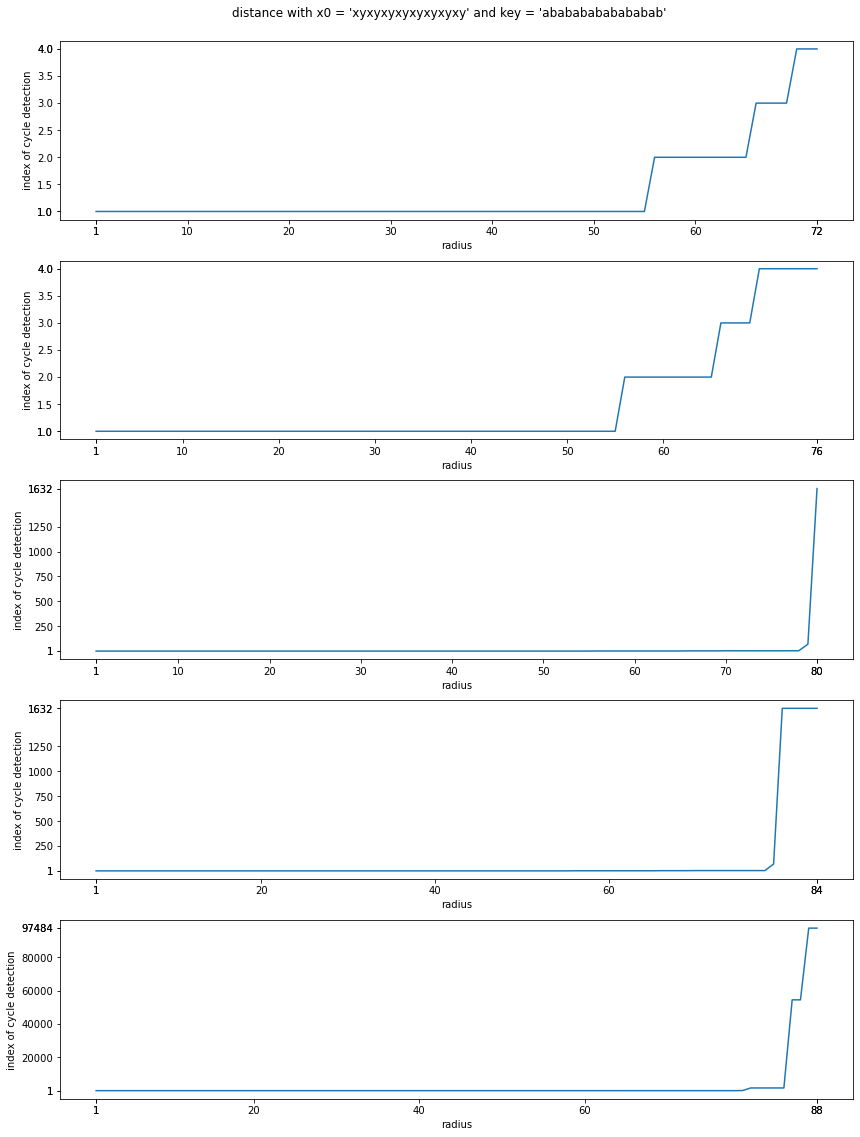

In [105]:
key = "ab" * 8
plain = "xy" * 8
maxRadiuses = [72, 76, 80, 84, 88]
maxRadiusCompare(plain, key, bitCommon, maxRadiuses)

Même sans interpréter les résultats, on remarque que les indexes sont moins élevés et que les paliers ne sont pas situés au mêmes endroits. Instinctivement, on s'attend assez logiquement à la même tendance avec la distance mesurant les caractères en commun, même si la detection des quasi-cycles sera évidement plus longue puisque les comparaisons ne se feront plus entre des `0` et des `1` mais entre des *bytes*.

À noter que les distances ne sont pas spécialement rapides ou optimisées car j'ai vite voulu me tourner vers la recherche d'une plus longue sous-chaine commune de caractères ou de bits au lieu de rester sur des différences de caractères ou de bits.

---

## III - Plus longue sous-chaine commune

Selon le sujet: *soient deux chaine de caractères, par exemple "xyzabcdef" et "abcdefg", la plus longue
sous-chaine commune est "abcdef" car on ne s’intéresse qu’aux sous-chaines de caractères
consécutives.*

### 1 - Fonctions de distance

Passons maintenant à la recherche d'une plus longue sous-chaine commune et prenons sa taille pour distance. C'est bien plus intéressant car dans le contexte d'un message chiffré, on cherche à trouver des "bouts" de message et donc on doit prendre en compte le fait que les caractères trouvés se **suivent**.

In [106]:
import difflib

def longestCommonSubstring(a, b, debug=False):
    """
    return longest common substring between a and b
    """
    assert len(a) == len(b), f"Strings have different length: len(a) = {len(a)}, len(b) = {len(b)}"
    match = difflib.SequenceMatcher(None, a, b)
    lcs = match.find_longest_match(0, len(a), 0, len(b))
    if debug:
        print(f"[+] returned object = {lcs}")
        print(f"[+] lcs = {a[lcs.a: lcs.a + lcs.size]}")
    return lcs

def bitDistance(a, b, debug=False):
    """
    return length of longest common substring between binary representations of a and b
    """
    assert len(a) == len(b), f"Strings have different length: len(a) = {len(a)}, len(b) = {len(b)}"
    bit_a = getBinary(a)
    bit_b = getBinary(b)
    bit_lcs = longestCommonSubstring(bit_a, bit_b, debug) # this time we pass `debug` too
    return bit_lcs.size

def charDistance(a, b, debug=False):
    """
    return length of longest common substring between a and b
    """
    lcs = longestCommonSubstring(a, b, debug)
    return lcs.size

### 2 - Premières observations

Tout est prêt pour vraiment commencer à jouer avec les quasi-cycles de sous-chaines de caractères consécutifs dans AES-128-ECB. Commençons par regarder le comportement général, comme lors des tests des deux fonctions de distance précédentes.

[+] computing...
[+] done in 92 secs


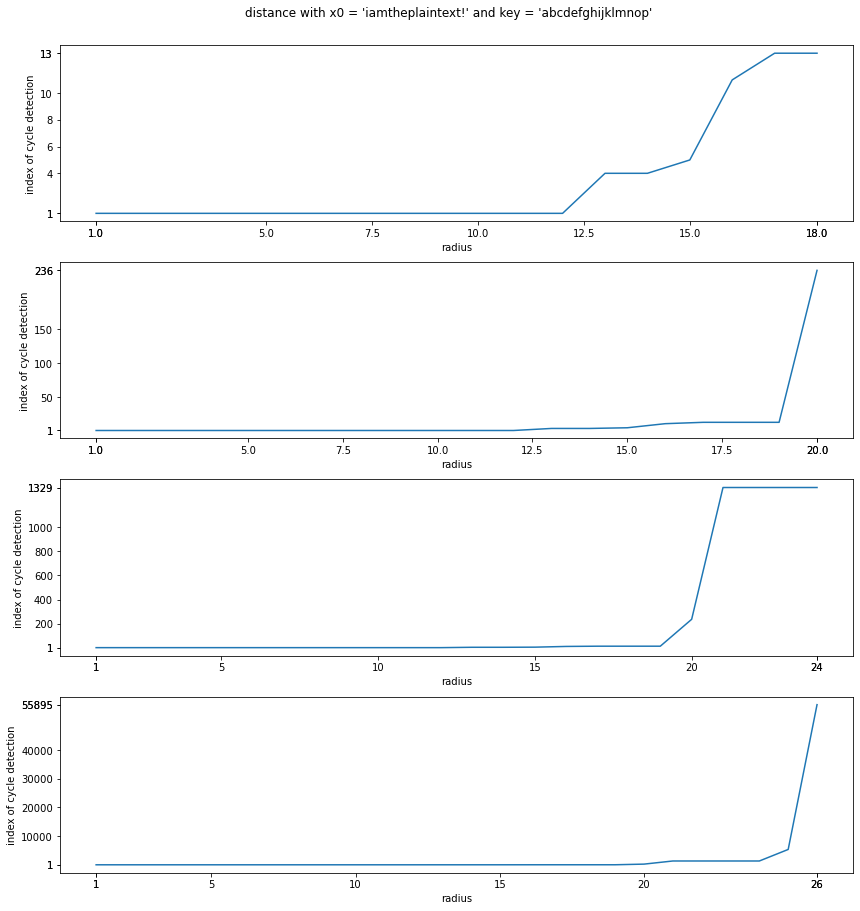

In [107]:
key = "abcdefghijklmnop"
plain = "iamtheplaintext!"
maxRadiusCompare(plain, key, bitDistance, [18, 20, 24, 26])

Intéressant, on constate encore la présence de paliers, et les différences à seulement 2 bits près suffisent pour rendre les indexes précédents négligeables. Faisons la même chose pour les caractères afin de confirmer l'intuition: on s'attend à des cycles naturellement plus longs à trouver, mais aux mêmes observations générales comme par exemple la formes des courbes.

[+] computing...
[+] done in 2 secs


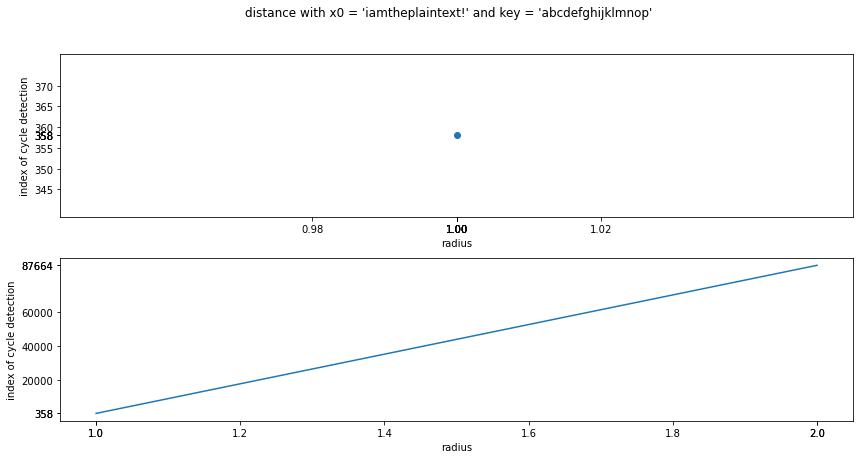

In [108]:
key = "abcdefghijklmnop"
plain = "iamtheplaintext!"
maxRadiusCompare(plain, key, charDistance, [1, 2])

Je me suis limité à 2 caractères communs consécutifs car pour 3 le temps de calcul devenait absurde. On voit qu'il suffit de quelques itérations pour 1 caractère commun alors qu'il faut beaucoup plus pour 2 caractères communs consécutifs. Si je m'attendais à une différence, je ne m'attendais pas à ce qu'elle soit si grande si vite, j'ai du mal à imaginer ce que ce serait pour 4 ou 5 caractères si je ne peux déjà pas exploiter 3 caractères consécutifs.

### 3 - Différence caractères - bits

Une telle différence vient du fait que les bits communs consécutifs peuvent commencer et / ou finir au milieu des lettres.

In [109]:
def compare(a, b):
    assert len(a) == len(b)
    cmp = ""
    for i in range(len(a)):
        if a[i] == b[i]:
            cmp += "*"
        else:
            cmp += " "
    return cmp

a = b"abcd"
b = b"qbfd"
bin_a = getBinary(a)
bin_b = getBinary(b)
print(f"[x] a = {a.decode('utf-8')} -> {bin_a}")
print(f"                {compare(bin_a, bin_b)}")
print(f"[x] b = {b.decode('utf-8')} -> {bin_b}")
print(f"[x] charDistance = {charDistance(a, b)}")
print(f"[x] binDistance = {bitDistance(a, b)}")

[x] a = abcd -> 01100001011000100110001101100100
                *** ***************** * ********
[x] b = qbfd -> 01110001011000100110011001100100
[x] charDistance = 1
[x] binDistance = 17


On voit bien qu'il y a **17 bits** communs consécutifs, donc l'équivalent de **2 caractères et 1 bit**. Pourtant, à cause du placement de ces bits, on a qu'**un seul caractère** en commun entre `a` et `b`.

Ce cas suffit à lui-seul à expliquer pourquoi il est relativement facile de trouver des plus longues sous-chaines communes de bits allant jusqu'à 26 bits, soit 3 caractères dans la théorie, alors qu'il est insupportablement long de trouver plus de 2 caractères communs en pratique. La recherche de caractères communs consécutifs est en fait une recherche de bits communs consécutifs auxquels on ajoute des contraintes: blocks correctement alignés et d'au moins 8 bits. Il apparait également que la distance avec les bits contiendrait aussi l'information sur la distance avec les caractères si on remontait également les indexes de début de sous-chaines et non simplement leurs tailles. Ça pourrait être intéressant plus tard si on veut exploiter ces chaines et non plus simplement les quasi-cycles.

---

## IV - Analyse sur des LCS de bits

Dans un premier temps j'ai décidé de me concentrer sur les sous-chaine de bits car il est plus simple de nuancer la borne (que j'appelle `radius`) avec des unités plus petites. Il serait intéressant de mettre en évidence l'existence de schémas dépendant du message initial et / ou de la clé.

### 1 - Message initial

Commençons par une clé fixe relativement normale, au sens où l'entropie n'est pas extrême d'un côté comme de l'autres, et un message initial qu'on va faire varier: entropie, présence de patterns ou encore taille.

In [110]:
def average(L):
    """
    return average value in list of integers
    """
    return sum(L) / len(L)

def buildGraph(axe, nb_graphs, legend, x, y):
    for i in range(nb_graphs):
        axe.plot(x, y[i])
    axe.set_xlabel("radius")
    axe.set_ylabel("index of cycle detection")
    # set x ticks
    xticks = axe.get_xticks()
    xticks[0], xticks[-1] = x[0], x[-1]
    xticks[1], xticks[-2] = xticks[0], xticks[-1]
    axe.set_xticks(xticks)
    # set y ticks
    yticks = axe.get_yticks()
    yticks[0], yticks[-1] = min([min(yi) for yi in y]), max([max(yi) for yi in y])
    yticks[1], yticks[-2] = yticks[0], yticks[-1]
    axe.set_yticks(yticks)
    axe.legend(legend)
    
def formatTime(secs):
    secs = str(float(secs)).split(".")
    secs = secs[0] + "." + secs[1][:2]
    return secs

def addFloydTime(floyd_times, legends, i, floyd_time):
    """
    add floydRadius time for each legend
    """
    floyd_times.append(floyd_time)
    legends[i] += f" - {formatTime(floyd_time)} s"
    
def printTimes(time_all, avg):
    print(f"[+] done in {formatTime(time_all)} secs")
    print(f"[+] average time for each plain = {formatTime(avg)} secs")
    
def printAvg(y):
    """
    print average value for y last values
    """
    l = [yi[-1] for yi in y]
    avg = sum(l) // len(l)
    print(f"[+] average cycle index for max radius = {avg}")

In [111]:
def plainCompare(plains, key, distance, maxRadius, height=5, width=12):
    """
    compare floydRadius(plain, key, distance, radius)
    for plain in plains
    """
    assert len(key) % 16 == 0 and (len(plain) % 16 == 0 for plain in plains)
    def encrypt_plain(plain): # to avoid passing `key` arg in `floydRadius`
        return encrypt(plain, key)

    # compute x and y values
    print("[+] computing...")
    start = time.time()
    x = np.linspace(1, maxRadius, maxRadius)
    y = []
    floyd_times = []
    for i in range(len(plains)):
        floyd_start = time.time()
        y.append([floydRadius(encrypt_plain, plains[i], distance, radius) for radius in x])
        floyd_end = time.time()
        addFloydTime(floyd_times, plains, i, floyd_end - floyd_start)
    end = time.time()
    printTimes(end - start, average(floyd_times))
    printAvg(y)

    # build fig
    nb_graphs = len(plains) # nb graphs
    fig, axs = plt.subplots(1)
    fig.suptitle(f"distance with different plains and key = '{key}'")
    fig.set_figheight(height)
    fig.set_figwidth(width)
    fig.tight_layout(pad=2)
    
    # build and show graphs
    buildGraph(axs, nb_graphs, plains, x, y)
        
    plt.show()

Il faut d'abord définir une référence pour les résultats. On utilisera la même `key`, le même `maxRadius` (la même *borne* maximum), la même taille de messages initiaux et le même nombre de chaines pour comparer les formes générales de courbes. Cette référence est un set de chaine de caractères *randoms*, chiffres et lettres.

In [112]:
key = "abcdefghijklmnop"
maxRadius = 24
size = 16
nGraphs = 20 # we MUST have `nGraphs % 4 == 0` <=> `4 | nGraphs`

Note: au-dessus sont définies les variables utiles pour tous les calculs de cette partie. C'est utile pour tout modifier d'un coup afin de garder les mêmes valeurs pour les comparaisons. Si on veut tester indépendamment les différentes parties en changeant ces valeurs, il vaut mieux passer la variable `local` à `True` et modifier les paramètres locaux afin de ne pas influencer les résultats postérieurs.

In [113]:
import random
import string

def getRandomString(size):
    charset = string.ascii_letters + string.digits
    return ''.join(random.choices(charset, k=size))

[+] computing...
[+] done in 244.58 secs
[+] average time for each plain = 12.22 secs
[+] average cycle index for max radius = 4546


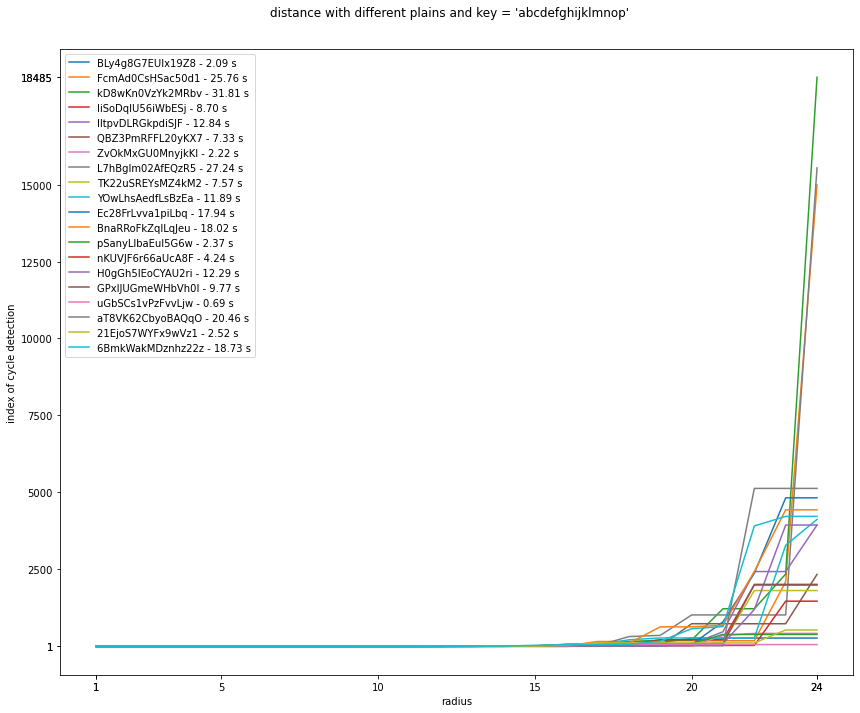

In [114]:
local = False

if local:
    l_key = "abcdefghijklmnop"
    l_maxRadius = 15
    l_size = 16
    l_nGraphs = 25
    plains = [getRandomString(l_size) for _ in range(l_nGraphs)]
    plainCompare(plains, l_key, bitDistance, l_maxRadius, height=10)
else:
    plains = [getRandomString(size) for _ in range(nGraphs)]
    plainCompare(plains, key, bitDistance, maxRadius, height=10)

#### a - Entropie

Voyons si l'entropie modifie le comportement des courbes. Par entropie j'entends ici à quel point la chaine est *chaotique*, au sens *à quel point les caractères sont cohérents les uns avec les autres, à quel point ils sont proches*. Une chaine avec un entropie faible est plus homogène.

[+] computing...
[+] done in 379.02 secs
[+] average time for each plain = 18.95 secs
[+] average cycle index for max radius = 8360


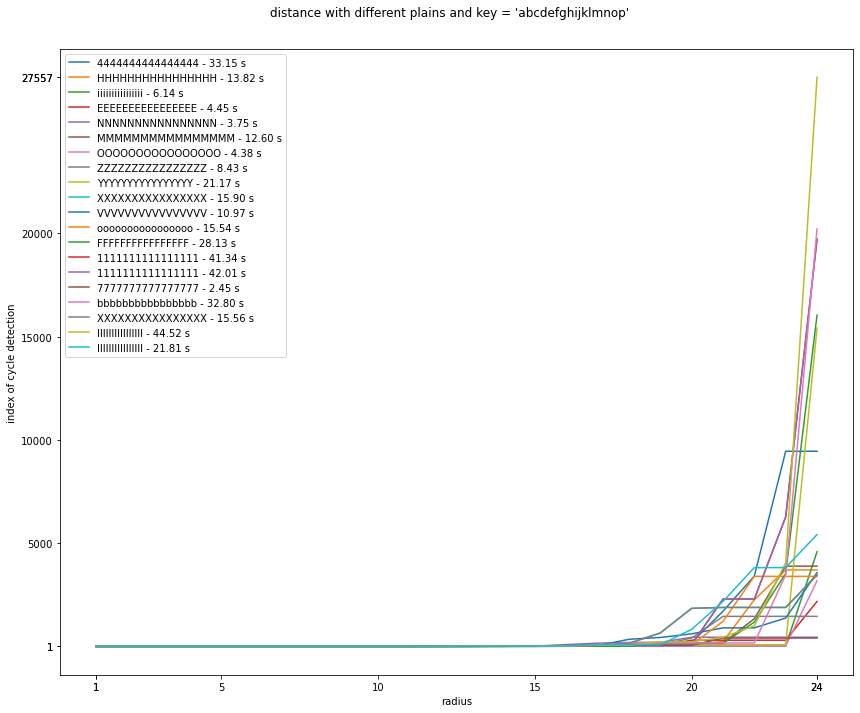

In [115]:
local = False

if local:
    l_key = "abcdefghijklmnop"
    l_maxRadius = 15
    l_size = 16
    l_nGraphs = 20
    plains = [l * l_size for l in getRandomString(l_nGraphs)]
    plainCompare(plains, l_key, bitDistance, l_maxRadius, height=10)
else:
    plains = [l * size for l in getRandomString(nGraphs)]
    plainCompare(plains, key, bitDistance, maxRadius, height=10)

Un message initial plus cohérent double l'index des quasi-cycles ainsi que les temps de calcul. Si j'ai du mal à expliquer ce phénomène, il est sûrement lié à l'implémentation d'AES, mais c'est assez peu intéressant dans la mesure où l'on cherche à diminuer le temps d'apparition des quasi-cycles.

#### b - Patterns

Après avoir vu qu'un message inital composé d'une lettre seulement, donc plus cohérent, diminuait la présence de cycles, on s'attend à ce que l'existence de patterns dans le message initial diminue la cohérence et donc que les résultats soient plus proches que ceux d'un message inital complètement aléatoire.

In [116]:
def buildPatterns(size, nGraphs):
    patterns = []
    for i in range(nGraphs // 4): # axaxax
        patterns.append(getRandomString(2) * (size // 2))
    for i in range(nGraphs // 4): # abcabcabc
        randomString = getRandomString(3)
        patterns.append(randomString * (size // 3) + randomString[:size % 3])
    for i in range(nGraphs // 4): # palindrome
        randomString = getRandomString(size // 2)
        patterns.append(randomString + randomString[::-1])
    for i in range(nGraphs // 4): # aaaabbbbcccc
        string = ""
        for i in range(size // 4):
            string += getRandomString(1) * (size // 4)
        patterns.append(string)
    return patterns

[+] computing...
[+] done in 271.54 secs
[+] average time for each plain = 13.57 secs
[+] average cycle index for max radius = 5980


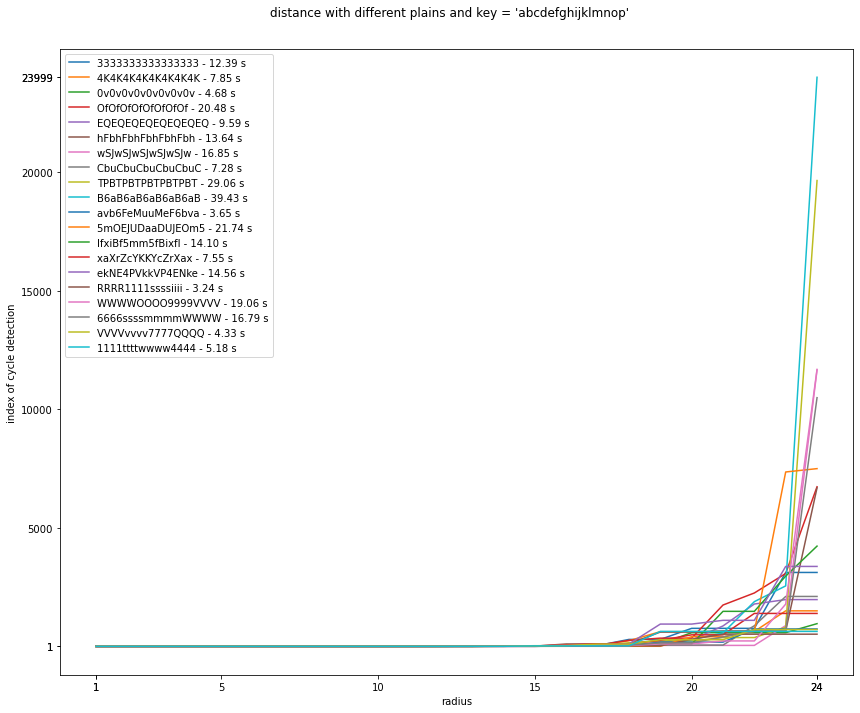

In [117]:
local = False

if local:
    l_key = "abcdefghijklmnop"
    l_maxRadius = 15
    l_size = 16
    l_nGraphs = 32
    plains = buildPatterns(l_size, l_nGraphs)
    plainCompare(plains, l_key, bitDistance, l_maxRadius, height=10)
else:
    plains = buildPatterns(size, nGraphs)
    plainCompare(plains, key, bitDistance, maxRadius, height=10)

Effectivement, c'est toujours les mêmes ordres de grandeur en moyenne.

#### c - Taille

Intuitivement, une chaine plus longue devrait drastiquement réduire l'index du cycle si l'on garde la même borne. En effet, plus de caractères offrent plus de chances que certains bits communs se suivent. Par contre les temps de calculs devraient être plus longs, car travailler sur des chaines plus longues demande plus de temps lors de la détection des LCS.

En revanche, avec une borne proportionnellement égale, on s'attend aux mêmes indexes à condition que les blocs soient **différents**. Cette contrainte vient du mode ECB qui chiffre les blocs indépendamment. Deux blocs identiques seront donc chiffrés de la même manière. Si les blocs sont les mêmes, on s'attend à avoir exactement les mêmes indexes que s'il n'y en avait qu'un.

[+] computing...
[+] done in 134.10 secs
[+] average time for each plain = 6.70 secs
[+] average cycle index for max radius = 38425


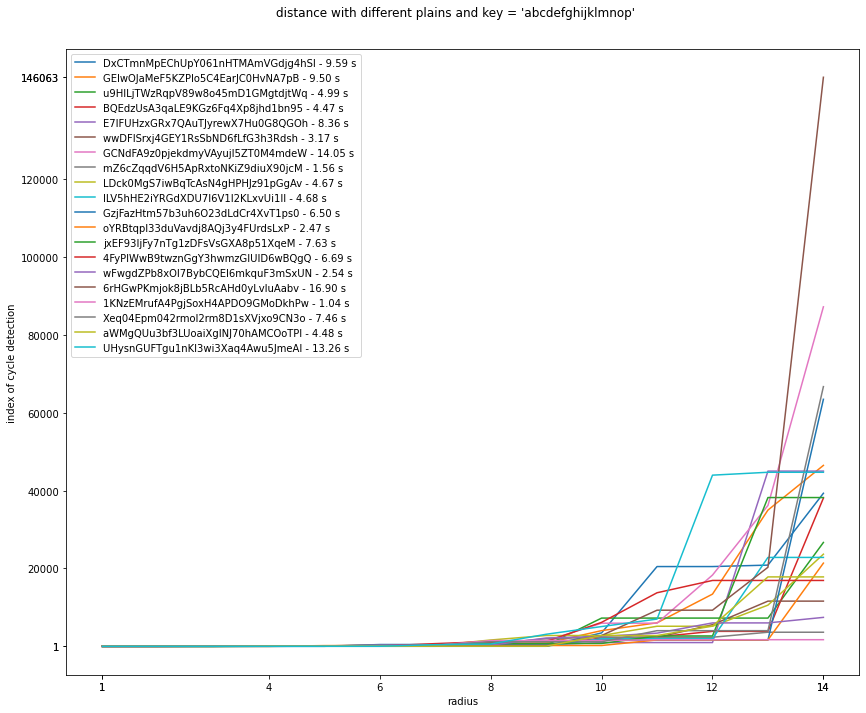

In [118]:
local = False

# different blocks
if local:
    l_key = "abcdefghijklmnop"
    l_maxRadius = 10
    l_size = 16
    l_nGraphs = 24
    plains = [getRandomString(l_size * 2) for _ in range(l_nGraphs)]
    plainCompare(plains, l_key, bitDistance, l_maxRadius, height=10)
else:
    s_maxRadius = 14 # could not go higher
    plains = [getRandomString(size * 2) for _ in range(nGraphs)]
    plainCompare(plains, key, bitDistance, s_maxRadius, height=10)

[+] computing...
[+] done in 108.75 secs
[+] average time for each plain = 5.43 secs
[+] average cycle index for max radius = 34643


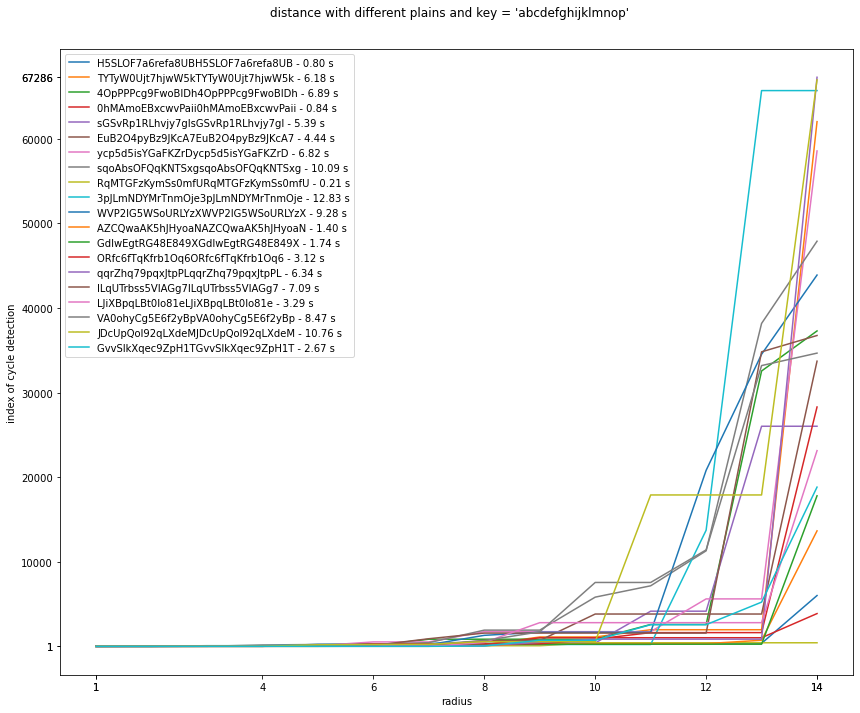

In [119]:
local = False

# same blocks
if local:
    l_key = "abcdefghijklmnop"
    l_maxRadius = 10
    l_size = 16
    l_nGraphs = 5
    plains = [getRandomString(l_size) * 2 for _ in range(l_nGraphs)]
    plainCompare(plains, l_key, bitDistance, l_maxRadius, height=10)
else:
    s_maxRadius = 14 # could not go higher
    plains = [getRandomString(size) * 2 for _ in range(nGraphs)]
    plainCompare(plains, key, bitDistance, s_maxRadius, height=10)

Les résultats sont plutôt surprenants par rapport aux attentes. Je n'ai même pas pu aller au-delà de 14 bits communs consécutifs. Que les blocs soient les mêmes ou non, en dehors des exceptions liées aux chaines aléatoires, la majorité des courbes tournent autour des mêmes indexes. De plus, s'il me paraissait normal que le calcul soit plus long avec des chaines plus longues, je pensais que les indexes seraient du même ordre de grandeur pour une même borne qu'avec des chaines moins longues.

### 1 - Clé

Fixons le message initial et voyons comment évoluent les courbes en faisant varier la clé.

In [120]:
def keyCompare(plain, keys, distance, maxRadius, height=5, width=12):
    """
    compare floydRadius(plain, key, distance, radius)
    for key in keys
    """
    assert len(plain) % 16 == 0 and (len(key) % 16 == 0 for key in keys)
    
    # compute x and y values
    print("[+] computing...")
    start = time.time()
    x = np.linspace(1, maxRadius, maxRadius)
    y = []
    floyd_times = []
    for i in range (len(keys)):
        # gotta define it again for each new key
        def encrypt_plain(plain): # to avoid passing `key` arg in `floydRadius`
            return encrypt(plain, keys[i])
        floyd_start = time.time()
        y.append([floydRadius(encrypt_plain, plain, distance, radius) for radius in x])
        floyd_end = time.time()
        addFloydTime(floyd_times, keys, i, floyd_end - floyd_start)
    end = time.time()
    printTimes(end - start, average(floyd_times))
    printAvg(y)
    
    # build fig
    nb_graphs = len(keys) # nb graphs
    fig, axs = plt.subplots(1)
    fig.suptitle(f"distance with plain {plain} and different keys")
    fig.set_figheight(height)
    fig.set_figwidth(width)
    fig.tight_layout(pad=2)
    
    # build and show graphs
    buildGraph(axs, nb_graphs, keys, x, y)
        
    plt.show()

On définit à nouveau une référence pour les résultats avec des clés aléatoires.

In [121]:
plain = "abcdefghijklmnop"
# uncomment to use new values for key manipulations:
# maxRadius = 22
# size = 16
# nGraphs = 20 # we MUST have `nGraphs % 4 == 0` <=> `4 | nGraphs`

[+] computing...
[+] done in 296.21 secs
[+] average time for each plain = 14.81 secs
[+] average cycle index for max radius = 5915


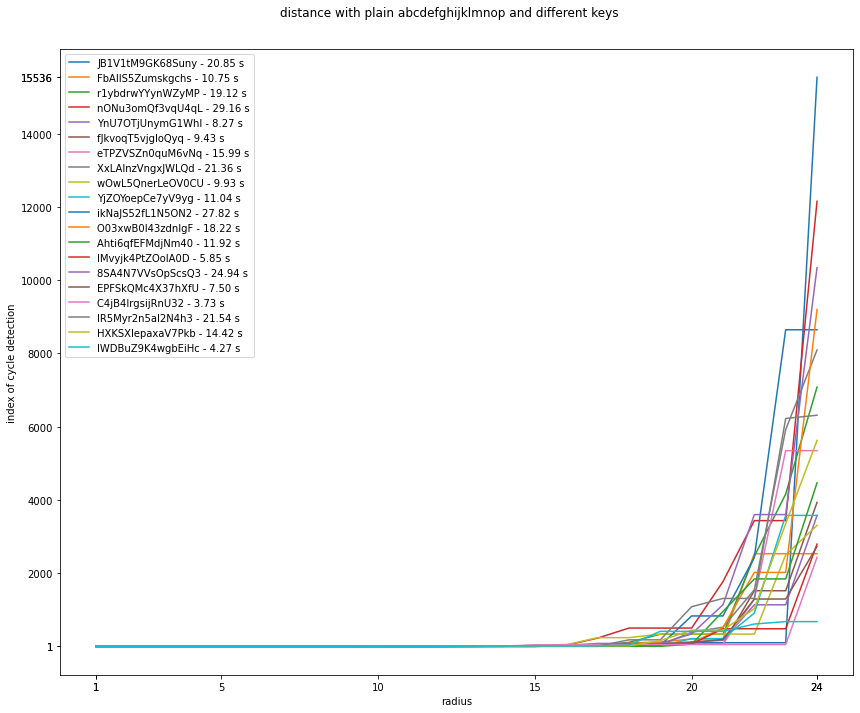

In [122]:
local = False

if local:
    l_plain = "abcdefghijklmnop"
    l_maxRadius = 25
    l_size = 16
    l_nGraphs = 20
    keys = [getRandomString(l_size) for _ in range(l_nGraphs)]
    keyCompare(l_plain, keys, bitDistance, l_maxRadius, height=10)
else:
    keys = [getRandomString(size) for _ in range(nGraphs)]
    keyCompare(plain, keys, bitDistance, maxRadius, height=10)

#### a - Entropie

[+] computing...
[+] done in 553.53 secs
[+] average time for each plain = 27.67 secs
[+] average cycle index for max radius = 13427


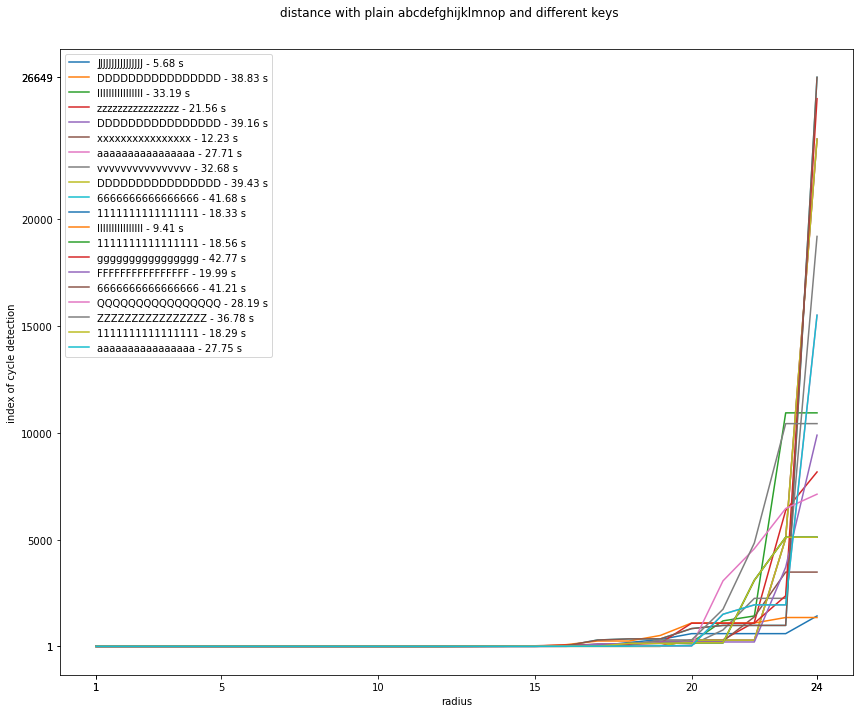

In [123]:
local = False

if local:
    l_plain = "abcdefghijklmnop"
    l_maxRadius = 25
    l_size = 16
    l_nGraphs = 20
    keys = [l * l_size for l in getRandomString(l_nGraphs)]
    keyCompare(l_plain, keys, bitDistance, l_maxRadius, height=10)
else:
    keys = [l * size for l in getRandomString(nGraphs)]
    keyCompare(plain, keys, bitDistance, maxRadius, height=10)

Une clé plus cohérente semble augmenter l'index des quasi-cycles ainsi que les temps de calcul. Encore une fois, cela est peut-être lié à l'implémentation d'AES, mais c'est assez peu intéressant dans la mesure où l'on cherche à diminuer le temps d'apparition des quasi-cycles. En réalité, comme vu juste après avec les patterns, seules les clés composées d'un seul et unique caractère, et pas n'importe lesquels **selon le message initial**, augmentent les temps de calcul, c'est donc peu voire pas exploitable.

#### b - Patterns

[+] computing...
[+] done in 325.62 secs
[+] average time for each plain = 16.28 secs
[+] average cycle index for max radius = 6424


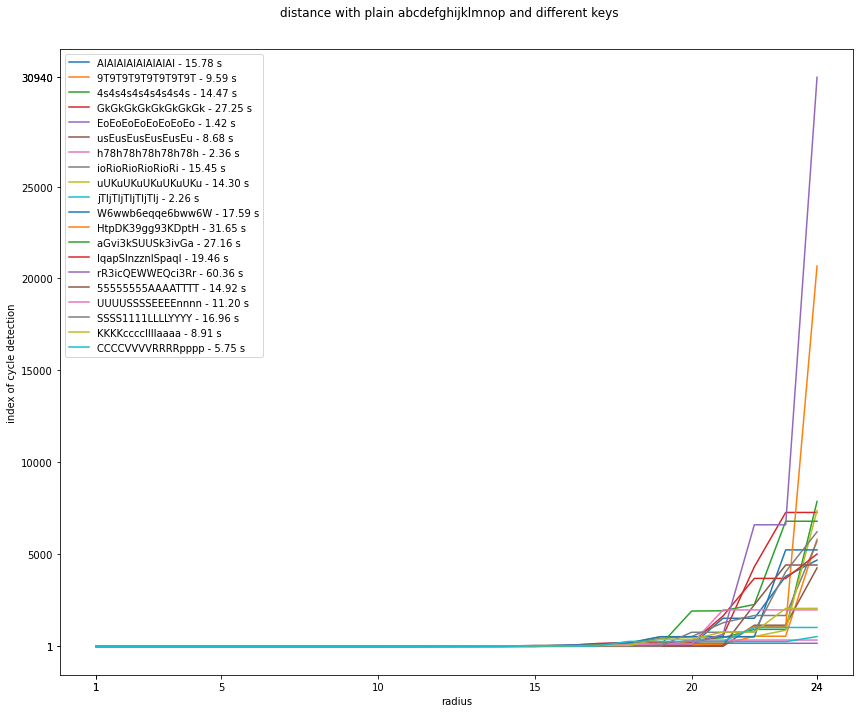

In [124]:
local = False

if local:
    l_plain = "abcdefghijklmnop"
    l_maxRadius = 15
    l_size = 16
    l_nGraphs = 32
    keyss = buildPatterns(l_size, l_nGraphs)
    keyCompare(l_plain, keys, bitDistance, l_maxRadius, height=10)
else:
    keys = buildPatterns(size, nGraphs)
    keyCompare(plain, keys, bitDistance, maxRadius, height=10)

Comme on s'y attendait encore, la présence de patterns dans la clé ne semble pas influencer l'index du quasi-cyle ni les temps de calcul, surtout lorsqu'on se rapproche d'une entropie plus forte.

#### c - Taille

On sort du cadre de AES-128 en augmentant la taille, mais il est toujours intéressant de voir quelle influence ça a. Essayons avec AES-256, soit une clé de 32 *bytes*.

[+] computing...
[+] done in 303.07 secs
[+] average time for each plain = 15.15 secs
[+] average cycle index for max radius = 5959


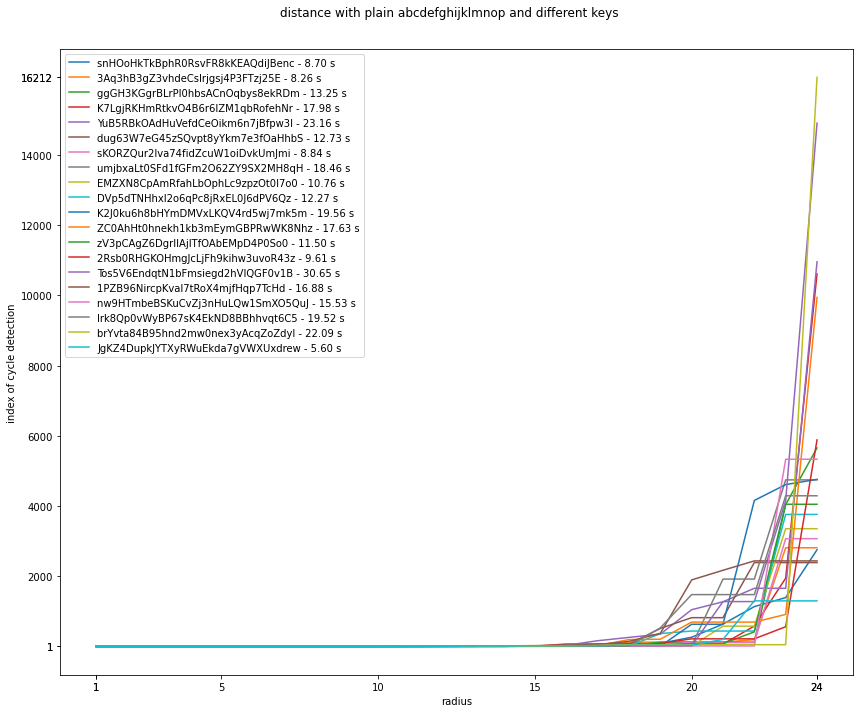

In [125]:
local = False

if local:
    l_plain = "abcdefghijklmnop"
    l_maxRadius = 10
    l_size = 16
    l_nGraphs = 24
    keys = [getRandomString(l_size * 2) for _ in range(l_nGraphs)]
    keyCompare(l_plain, keys, bitDistance, l_maxRadius, height=10)
else:
    keys = [getRandomString(size * 2) for _ in range(nGraphs)]
    keyCompare(plain, keys, bitDistance, maxRadius, height=10)

Encore une fois, la taille de la clé n'a aucune influence. Je pensais au début qu'avec (beaucoup) plus de temps de calcul sur des bornes plus hautes, on aurait des indexes de quasi-cyles plus grands, et donc des temps de calcul plus élevés. En effet en dehors des détails d'implémentation d'AES, si une clé plus longue est plus sécurisée, on peut facilement supposer qu'elle promet encore moins de cohérence entre le message en clair et le message chiffré. Néanmoins, il est important de noter que jusqu'ici, **aucun** paramètre ne **semble** influencer l'apparition de quasi-cyles, pour les bornes choisies. Cette première intuition est donc peut-être complètement erronée si les quasi-cyles ne sont que le fruit du hasard, ou en tout cas que ni la clé ni le message initial n'influencent les probabilités.

---

## V - Conclusion

Pour conclure, je n'ai pas trouvé de *patterns* qui dépendent du message initial `x0` ou de la clé de chiffrement `key` dans la recherche de quasi-cycles pour l'algorithme de chiffrement AES-128-ECB. En revanche, on ne peut pas en conclure pour autant que l'apparition de ces cycles est indépendantes de ces deux paramètres car un spectre très réduit de cas particulier a été testé ici. En plus d'être limité par le temps de calcul des scripts, il faut prendre en compte le fait que les chaines générées aléatoirement peuvent facilement fausser les observations si on tombe sur un extrême qui n'a pas de propriété particulière autre que prendre plus ou moins de temps que la moyenne attendue pour trouver un cycle approché.

Néanmoins, il aurait pu être intéressant d'étudier non plus seulement l'index auquel le quasi-cyle est detecté par l'algorithme de Floyd mais également $\mu$ et $\lambda$ les propriétés du quasi-cycle, soit sa taille et son temps de démarrage. Si je ne me suis pas penché sur ces résultats car tous les temps de calcul devenaient absurdes pour des bornes trop basses pour être exploitables, j'ai tout de même voulu savoir si la position des sous-chaines communes de bits pouvait être influencées par les paramètres étudiés, sans réel succès. En effet les résultats semblent tout aussi indépendants des paramètres (`x0`, `key`) que pour l'index du quasi-cycle.

Pour autant, il était très intéressant de jouer avec AES-128-ECB et ses cycles approchés. Même sans résultat concluant sur l'existence de schémas dépendants du message clair et de la clé dans les sous-chaines communes de bits, j'ai compris qu'il était plus intéressant d'étudier un sujet profondément et de dériver sur les questions qu'il soulève que de vouloir survoler trop de choses dès le début.

---

## Bonus

Je trouvais ça intéressant de mettre ici le script que j'ai (beaucoup) utilisé pour générer facilement le sommaire, comme j'étais assez content de mon idée.

In [126]:
#!/usr/bin/python3

import json
import os

def getTOC(notebook):
    """
    generate TOC for `notebook`: `.ipynb` file 
    """
    # open, read and close file
    f = open(notebook, "r")
    data = json.load(f)
    f.close()
    # get markdown cells
    text = ""
    for cell in (data['cells']):
        if cell['cell_type'] == "markdown":
            for line in cell['source']:
                text += line
            text += "\n\n"
    # tmp file with markdown
    md = open("notebookMarkdown.md", "w")
    md.write(text)
    md.close()
    # generate TOC
    os.system("markdown-toc --no-firsth1 notebookMarkdown.md")
    os.system("rm -f notebookMarkdown.md")

---

## Fin du timer

Lorsque tous les calculs du document sont finis, le script suivant confirme et donne le temps total de calcul.

In [127]:
global_end = time.time()
computation_time = datetime.timedelta(seconds=global_end-global_start)
L = str(computation_time).split(":")
t = f"{int(L[1])} mins and {round(float((L[2])))} secs"
print(f"[x] computing over in {t}")
print("[x] check validated - you can now enjoy this document")

[x] computing over in 45 mins and 34 secs
[x] check validated - you can now enjoy this document
